# Feldstein-Horioka Analysis Tools

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import seaborn as sns
import numpy as np
from scipy import stats



# Data Preparation 1

In [5]:
import pandas as pd

# Read the Excel file into a DataFrame
df = pd.read_excel('WEO_clean.xlsx')

# Melt the DataFrame to long format
df_long = df.melt(id_vars=['country'], var_name='year_var', value_name='value')

# Separate variable and year
df_long[['var', 'year']] = df_long['year_var'].str.split('_', expand=True)

# Convert year to integer
df_long['year'] = df_long['year'].astype(int)

# Pivot the table to have separate columns for 'i' and 's'
df_wide = df_long.pivot(index=['country', 'year'], columns='var', values='value').reset_index()

# Rename columns
df_wide.columns.name = None

# Adjust the color_group to ensure data up to 2021 is included
df_wide['color_group'] = pd.cut(df_wide['year'], 
                                bins=[1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2022],  # Include 2022 so 2021 is considered
                                labels=["1985-1989", "1990-1994", "1995-1999", "2000-2004", "2005-2009", "2010-2014", "2015-2019", "2020-2021"], 
                                right=False)

# Adjust the groups in your loop
groups = ["1985-1989", "1990-1994", "1995-1999", "2000-2004", "2005-2009", "2010-2014", "2015-2019", "2020-2021"]
for group in groups:
    if group not in df_timeframe['color_group'].unique():
        temp_df = pd.DataFrame({'s': [None], 'i': [None], 'color_group': [group]})
        df_timeframe = pd.concat([df_timeframe, temp_df], ignore_index=True)

# Print the resulting DataFrame
print(df_wide)


        country  year       i       s color_group
0     Argentina  1985  13.950  17.241   1985-1989
1     Argentina  1986  13.977  16.215   1985-1989
2     Argentina  1987  15.698  14.533   1985-1989
3     Argentina  1988  15.063  15.567   1985-1989
4     Argentina  1989  12.465  15.071   1985-1989
...         ...   ...     ...     ...         ...
1697    Vietnam  2017  32.305  31.709   2015-2019
1698    Vietnam  2018  32.020  33.914   2015-2019
1699    Vietnam  2019  31.980  35.647   2015-2019
1700    Vietnam  2020  31.916  36.265   2020-2021
1701    Vietnam  2021  33.467  31.339   2020-2021

[1702 rows x 5 columns]


# Data Preparation 2

In [2]:
# Melt to long format
df_long2 = df.melt(id_vars=['country'], var_name='year_var', value_name='value')

# Separate variable and year
df_long2[['var', 'year']] = df_long2['year_var'].str.split('_', expand=True)

# Convert year to integer
df_long2['year'] = df_long2['year'].astype(int)

# Pivot table to have separate columns for 'i' and 's'
df_wide2 = df_long2.pivot_table(index=['country', 'year'], columns='var', values='value').reset_index()
df_wide2.set_index(['country', 'year'], inplace=True)

# Melt the dataframe
df_long2 = df.melt(id_vars=['country'], var_name='variable_year', value_name='value')

# Split the variable and year
df_long2['variable'] = df_long2['variable_year'].str[0]
df_long2['year'] = df_long2['variable_year'].str[2:]

# Pivot the dataframe to separate columns for i and s
df_pivot = df_long2.pivot_table(index=['country', 'year'], columns='variable', values='value').reset_index()

# If you want a MultiIndex
df_pivot.set_index(['country', 'year'], inplace=True)

# Convert year values from string to int
df_pivot.index = df_pivot.index.set_levels(df_pivot.index.levels[0], level=0) # Ensure countries remain as string (if they are the level 0)
df_pivot.index = df_pivot.index.set_levels(df_pivot.index.levels[1].astype(int), level=1) # Convert years to int (assuming they are the level 1)


print(df_pivot)

variable             i       s
country   year                
Argentina 1985  13.950  17.241
          1986  13.977  16.215
          1987  15.698  14.533
          1988  15.063  15.567
          1989  12.465  15.071
...                ...     ...
Vietnam   2017  32.305  31.709
          2018  32.020  33.914
          2019  31.980  35.647
          2020  31.916  36.265
          2021  33.467  31.339

[1702 rows x 2 columns]


# Basic Scatterplots (All Data) 

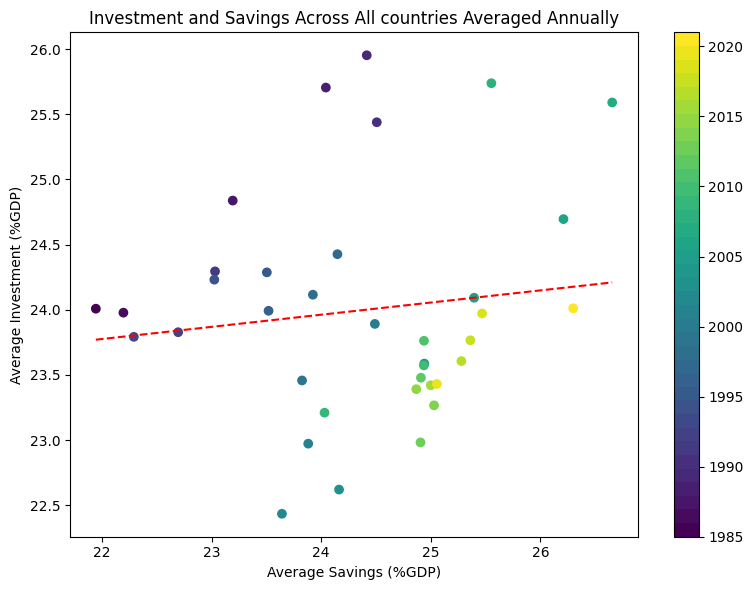

In [6]:
# Specify time frame
start_year = 1985
end_year = 2021

# Filter data for the given time frame
df_timeframe = df_wide.query(f"{start_year} <= year <= {end_year}")

# Group by 'year' and calculate the means of 'i' and 's' for each year
df_grouped = df_timeframe.groupby('year')[['i', 's']].mean().reset_index()

# Create a scatterplot of the average 'i' and 's' for each year with a color continuum
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap('viridis', len(df_grouped['year'].unique()))
sc = plt.scatter(data=df_grouped, x='s', y='i', c=df_grouped['year'], cmap=cmap)

plt.title('Investment and Savings Across All countries Averaged Annually')
plt.xlabel('Average Savings (%GDP)')
plt.ylabel('Average Investment (%GDP)')

# Add a colorbar to represent the years as a continuum
cbar = plt.colorbar()

# Calculate the regression coefficients for the best-fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_grouped['s'], df_grouped['i'])

# Plot the regression line
x_values = np.linspace(df_grouped['s'].min(), df_grouped['s'].max(), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, color='red', linestyle='--', label='Regression Line')

# Create a text box for the regression line equation in the bottom right
#text_box = f'Regression Line Equation:\n\ni = {intercept:.4f} + {slope:.4f} * s\n\nR-squared = {r_value**2:.2f}'
#plt.annotate(text_box, xy=(1.3, .8), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Remove the regression line from the legend
#handles, labels = plt.gca().get_legend_handles_labels()
#handles = [h for i, h in enumerate(handles) if i != 1]
#labels = [l for i, l in enumerate(labels) if i != 1]

#plt.legend(handles, labels, title='Year', bbox_to_anchor=(1.2, 1), loc='upper left')
plt.tight_layout()

# You can adjust the axis scales if needed
# plt.xlim(-100, 100)
# plt.ylim(-100, 100)

plt.show()



# Scatter plot with regression

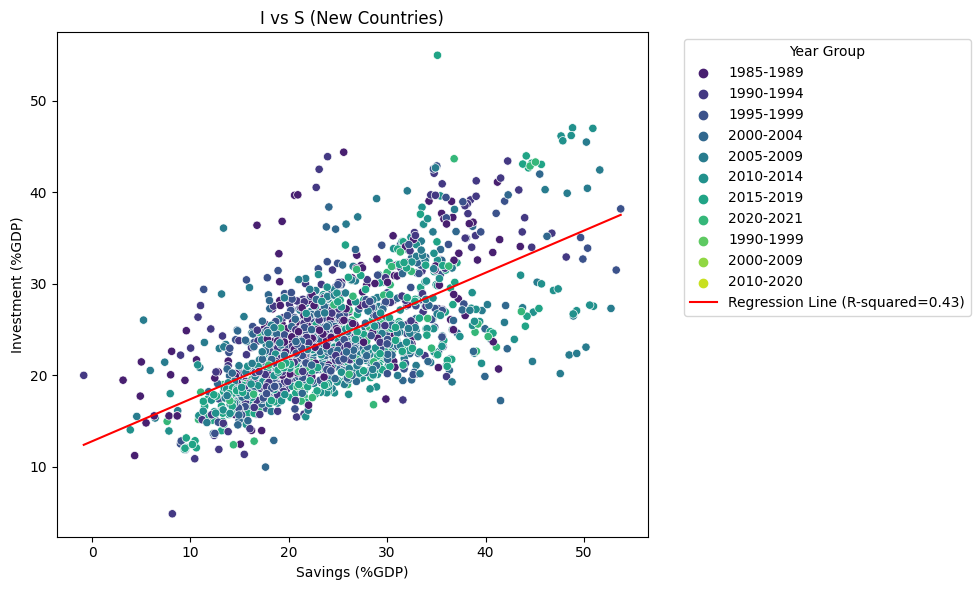

In [9]:
# Step 2: Filter the dataset for the desired timeframe
start_year = 1985
end_year = 2021

df_timeframe = df_wide[(df_wide['year'] >= start_year) & (df_wide['year'] <= end_year)]

# Step 3: Ensure all groups are present
for group in ["1985-1989", "1990-1999", "2000-2009", "2010-2020"]:
    if group not in df_timeframe['color_group'].unique():
        temp_df = pd.DataFrame({'s': [None], 'i': [None], 'color_group': [group], 'year': [None], 'country': [None]})
        df_timeframe = pd.concat([df_timeframe, temp_df], ignore_index=True)

# Drop NaN values before regression
df_timeframe_for_regression = df_timeframe.dropna(subset=['s', 'i'])

# Calculate the regression coefficients for the best-fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_timeframe_for_regression['s'], df_timeframe_for_regression['i'])

# Step 4: Plot the scatterplot without outliers and add the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_timeframe, x='s', y='i', hue='color_group', palette='viridis')

# Plot the regression line
x_values = np.linspace(df_timeframe['s'].min(), df_timeframe['s'].max(), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, color='red', label=f'Regression Line (R-squared={r_value**2:.2f})')

# Set plot title, labels, and legend
plt.title('Investment vs Savings (New Countries)')
plt.xlabel('Savings (%GDP)')
plt.ylabel('Investment (%GDP)')
plt.legend(title='Year Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the scatterplot
plt.show()


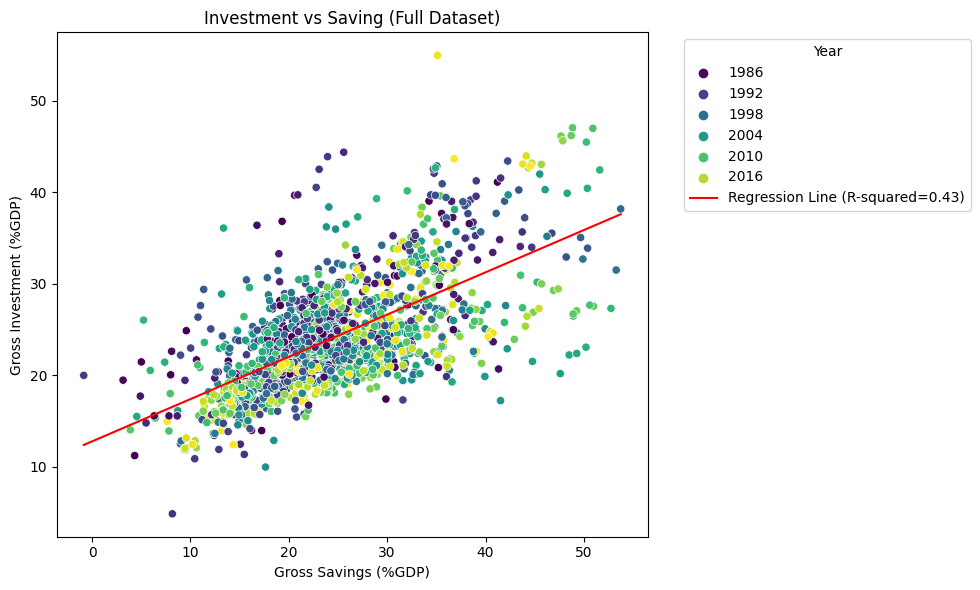

In [31]:
# Step 2: Filter the dataset for the desired timeframe
start_year = 1985
end_year = 2020

df_timeframe = df_wide[(df_wide['year'] >= start_year) & (df_wide['year'] <= end_year)]

# Drop NaN values before regression
df_timeframe_for_regression = df_timeframe.dropna(subset=['s', 'i'])

# Calculate the regression coefficients for the best-fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_timeframe_for_regression['s'], df_timeframe_for_regression['i'])

# Step 4: Plot the scatterplot without outliers and add the regression line
plt.figure(figsize=(10, 6))
# Use 'year' for hue to create a color spectrum based on year
sns.scatterplot(data=df_timeframe, x='s', y='i', hue='year', palette='viridis', legend='auto')

# Plot the regression line
x_values = np.linspace(df_timeframe['s'].min(), df_timeframe['s'].max(), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, color='red', label=f'Regression Line (R-squared={r_value**2:.2f})')

# Set plot title, labels, and legend
plt.title('Investment vs Saving (Full Dataset)')
plt.xlabel('Gross Savings (%GDP)')
plt.ylabel('Gross Investment (%GDP)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the scatterplot
plt.show()


# Scatterplot (Filtered, w/regression & outliers removed)

Outliers not included in the scatterplot:
           country    year       i       s color_group
267          China  1993.0  43.401  42.253   1990-1994
278          China  2004.0  41.973  45.509   2000-2004
281          China  2007.0  40.421  50.354   2005-2009
282          China  2008.0  42.425  51.613   2005-2009
283          China  2009.0  45.469  50.249   2005-2009
284          China  2010.0  46.968  50.909   2010-2014
285          China  2011.0  47.029  48.846   2010-2014
286          China  2012.0  46.186  48.708   2010-2014
287          China  2013.0  46.136  47.676   2010-2014
288          China  2014.0  45.612  47.855   2010-2014
289          China  2015.0  43.033  45.669   2015-2019
290          China  2016.0  42.655  44.359   2015-2019
291          China  2017.0  43.172  44.710   2015-2019
292          China  2018.0  43.961  44.136   2015-2019
293          China  2019.0  43.068  43.786   2015-2019
294          China  2020.0  42.857  44.531   2020-2021
295          China  202

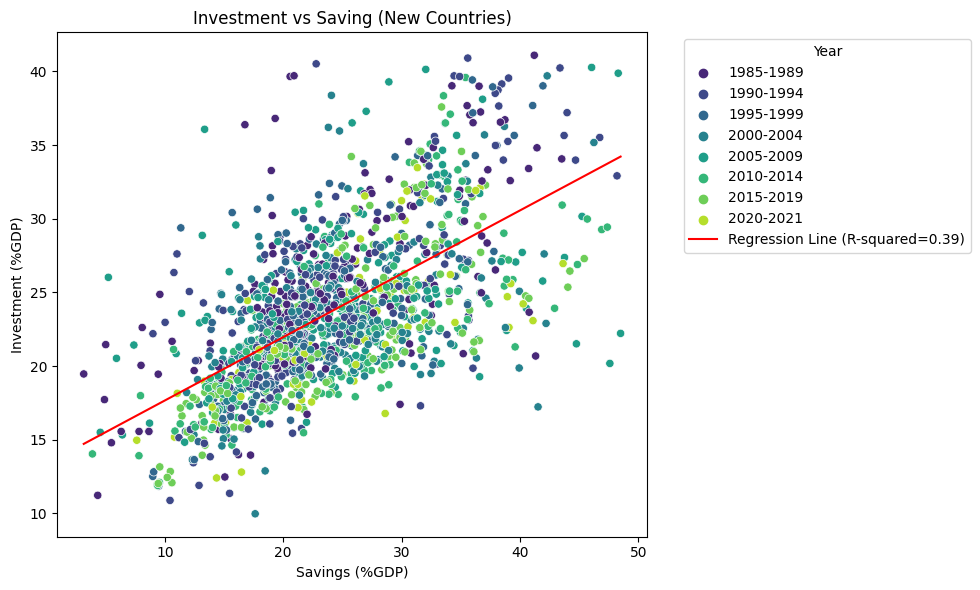

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Step 2: Filter the dataset for the desired timeframe
start_year = 1985
end_year = 2021
df_timeframe = df_wide[(df_wide['year'] >= start_year) & (df_wide['year'] <= end_year)]

# Step 3: Ensure all groups are present
for group in ["1980-1989", "1990-1999", "2000-2009", "2010-2017"]:
    if group not in df_timeframe['color_group'].unique():
        temp_df = pd.DataFrame({'s': [None], 'i': [None], 'color_group': [group]})
        df_timeframe = pd.concat([df_timeframe, temp_df], ignore_index=True)

# Define z-score threshold for outlier removal (e.g., |z-score| <= 3)
z_threshold = 3

# Calculate z-scores for 's' and 'i' columns
z_scores = np.abs((df_timeframe[['s', 'i']] - df_timeframe[['s', 'i']].mean()) / df_timeframe[['s', 'i']].std())

# Identify outliers based on z-scores
outliers = df_timeframe[(z_scores['s'] > z_threshold) | (z_scores['i'] > z_threshold)]

# Remove outliers from the DataFrame
df_no_outliers = df_timeframe[(z_scores['s'] <= z_threshold) & (z_scores['i'] <= z_threshold)]

# Calculate the regression coefficients for the best-fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_no_outliers['s'].dropna(), df_no_outliers['i'].dropna())

# Step 4: Plot the scatterplot without outliers and add the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='s', y='i', hue='color_group', palette='viridis')

# Plot the regression line
x_values = np.linspace(df_no_outliers['s'].min(), df_no_outliers['s'].max(), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, color='red', label=f'Regression Line (R-squared={r_value**2:.2f})')

# Set plot title, labels, and legend
plt.title('Investment vs Saving (New Countries)')
plt.xlabel('Savings (%GDP)')
plt.ylabel('Investment (%GDP)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


# Print the outliers
print("Outliers not included in the scatterplot:")
print(outliers)

# Print the regression line equation
print(f"Regression Line Equation: i = {intercept:.2f} + {slope:.2f} * s")

plt.show()


# Basc OLS Regression by timeframe

In [25]:
# specify time frame
start_year = 1985
end_year = 2021


# Filter data for the given time frame
df_timeframe = df_wide.query(f"{start_year} <= year <= {end_year}")

# define dependent variable
Y = df_timeframe['i']

# define independent variables
X = df_timeframe[['s']]

# add constant to independent variables
X = sm.add_constant(X)

# create model using OLS (Ordinary Least Squares) for standard linear regression
model = sm.OLS(Y, X)

# fit model
result = model.fit()

# print results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      i   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     1265.
Date:                Sun, 01 Oct 2023   Prob (F-statistic):          1.36e-207
Time:                        23:48:36   Log-Likelihood:                -4912.4
No. Observations:                1702   AIC:                             9829.
Df Residuals:                    1700   BIC:                             9840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7844      0.332     38.470      0.0

# Basic OLS Regression by timeframe (average value for each year)

In [13]:
# Specify time frame
start_year = 1985
end_year = 2021

# Filter data for the given time frame
df_timeframe = df_wide.query(f"{start_year} <= year <= {end_year}")

# Group by 'year' and calculate the means of 'i' and 's' for each year
df_grouped = df_timeframe.groupby('year')[['i', 's']].mean().reset_index()

# Define dependent variable
Y = df_grouped['i']

# Define independent variable
X = df_grouped[['s']]

# Add constant to independent variables
X = sm.add_constant(X)

# Create model using OLS (Ordinary Least Squares) for standard linear regression
model = sm.OLS(Y, X)

# Fit model
result = model.fit()

# Print results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      i   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.5588
Date:                Sun, 01 Oct 2023   Prob (F-statistic):              0.460
Time:                        22:46:34   Log-Likelihood:                -45.583
No. Observations:                  37   AIC:                             95.17
Df Residuals:                      35   BIC:                             98.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7227      3.044      7.136      0.0

# OLS Panel Regression by timeframe

In [29]:
# specify time frame
start_year = 1985
end_year = 2021

# Filter data for the given time frame
df_timeframe = df_pivot.query(f"{start_year} <= year <= {end_year}")

# Define dependent variable as a DataFrame
Y = df_timeframe[['i']]  # Use double brackets to create a DataFrame

# Define independent variables
X = df_timeframe[['s']]

# Add constant to independent variables
X = sm.add_constant(X)

# Create model
model = PanelOLS(Y, X, entity_effects=True, time_effects=False)  # Specify entity_effects=True or time_effects=True for desired fixed effects

# Fit model
result = model.fit()

# Print out the regression equation in terms of 'i'
print("Regression Equation:")
coefficients = result.params
intercept = coefficients['const']
slope_s = coefficients['s']
print(f"i = {intercept:.4f} + {slope_s:.4f} * s")

# Print other results
print(result)

Regression Equation:
i = 14.6872 + 0.3822 * s
                          PanelOLS Estimation Summary                           
Dep. Variable:                      i   R-squared:                        0.2098
Estimator:                   PanelOLS   R-squared (Between):              0.5605
No. Observations:                1702   R-squared (Within):               0.2098
Date:                Sun, Oct 01 2023   R-squared (Overall):              0.4144
Time:                        23:59:39   Log-likelihood                   -4440.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      439.41
Entities:                          46   P-value                           0.0000
Avg Obs:                       37.000   Distribution:                  F(1,1655)
Min Obs:                       37.000                                           
Max Obs:                       37.000   F-statistic (robust):  